# Challenge - Facial Emotion Recognition (FER)
## Computer Vision meets Facial Expressions.
Rules:
* only use the provided data // no external data allowed!!!
* The evaluation Metric will be the [weighted F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

### Data

You will be given three files:

1. *train_images.tar.gz*: This zip file contains the training folder which is compromised of 5 subfolders, each representing a specific emotion including angry, fear, happy, sad, surprise. Each image within a subfolder is correspodning to that emotion. 

2. *test_images.tar.gz*: This zip file contains a folder which comprises the 2,388 test images.

3. *submission.csv*: This csv file should serve as the final submission template. It simply contains the number of all test images. Please predict the emotion for each image and append another column which presents the emotion accordingly.

You can find the data [here](https://uni-koeln.sciebo.de/s/vPcXOe9uIyiuo2G).  



## Code

#### Imports

In [15]:
# Standard Library Imports
import os
import sys
import time

from os import listdir, mkdir, rename
from shutil import copyfile
from collections import Counter


# Third-Party Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import plotly.express as px
from tqdm import tqdm
from PIL import Image

# PyTorch Imports
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler
from torch import optim

import torchvision
import torchvision.transforms.functional as TF

from torchvision import *
from torchvision.utils import make_grid
from torchvision.models import (resnet18, shufflenetv2, resnet50, efficientnet_b0, inception_v3, mobilenetv3,
                                mnasnet, googlenet, shufflenetv2)

# Additional Libraries/Modules
import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


### Create own Validation and Training Set

In [17]:
# Create a validationset from the training set 

input_folder = "train"

# Split with a ratio.
#splitfolders.ratio(input_folder, output="train_split", 
 #                  seed=42, ratio=(.8, .2), 
  #                 group_prefix=None) 


## Data Import

In [68]:
# Define the transformations for training images in the pipeline
transformer_train = transforms.Compose([transforms.Resize((224,224)),
                                  #transforms.Grayscale(num_output_channels=1),
                                  transforms.RandomApply(transforms = [
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(25),
                                    #transforms.RandomSolarize(50, p=0.3),
                                    #transforms.RandomAutocontrast(p=0.3),
                                    transforms.RandomInvert(p=0.5),
                                    transforms.ColorJitter(brightness =.5), #  contrast=.1, hue=.2, saturation=.2
                                    transforms.RandomAffine(degrees=0,translate=(0.01, 0.12),shear=(0.01, 0.03))] , p=0.7),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 

# Define the transformations for training images in the transformer_train_inception pipeline
transformer_train_inception = transforms.Compose([transforms.Resize((299,299)),
                                  #transforms.Grayscale(num_output_channels=1),
                                  transforms.RandomApply(transforms = [
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(25),
                                    #transforms.RandomSolarize(50, p=0.3),
                                    #transforms.RandomAutocontrast(p=0.3),
                                    transforms.RandomInvert(p=0.5),
                                    transforms.ColorJitter(brightness =.5), #  contrast=.1, hue=.2, saturation=.2
                                    transforms.RandomAffine(degrees=0,translate=(0.01, 0.12),shear=(0.01, 0.03))] , p=0.7),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) 


# Define the transformations for later test images in the pipeline
transformer_test = transforms.Compose([transforms.Resize((224,224)),
                                        transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 # transforms.Grayscale(num_output_channels=1)
                                  ]) 

transformer_test_inception = transforms.Compose([transforms.Resize((299,299)),
                                        transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 # transforms.Grayscale(num_output_channels=1)
                                  ]) 




# Create torchvision datasets for the pipeling
train_data = torchvision.datasets.ImageFolder('train_split/train', transform = transformer_train)
val_data = torchvision.datasets.ImageFolder('train_split/val', transform = transformer_test)

inception_train_data = torchvision.datasets.ImageFolder('train_split/train', transform = transformer_train_inception)
inception_val_data = torchvision.datasets.ImageFolder('train_split/val', transform = transformer_test_inception)

test_data = torchvision.datasets.ImageFolder('test', transform = transformer_test)
inception_test_data = torchvision.datasets.ImageFolder('test', transform = transformer_test_inception)

In [69]:
# create a weighted sampler, that can be used in the Dataloader

y_train = train_data.targets

# Count the number of samples in each class
class_sample_count = np.bincount(y_train)

# Calculate the weight for each class
weight = 1. / class_sample_count

# Assign the weight to each sample based on its class
samples_weight = weight[y_train]

# Convert the weights to a PyTorch tensor
samples_weight = torch.from_numpy(samples_weight)

# Create a WeightedRandomSampler to be used in the training DataLoader
train_count = len(train_data)
sampler = WeightedRandomSampler(samples_weight, train_count, replacement=True)



In [20]:
# Create Data loaders for later training 
num_workers = 8

train_dl = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle = True, pin_memory = True, num_workers = num_workers)
inception_train_dl = torch.utils.data.DataLoader(inception_train_data, batch_size=64, shuffle = True, pin_memory = True,  num_workers = num_workers )

val_dl = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle = False, pin_memory = False,  num_workers = num_workers)
inception_val_dl = torch.utils.data.DataLoader(inception_val_data, batch_size=64, shuffle = False, pin_memory = True,  num_workers = num_workers)

test_dl = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle = False, pin_memory = False,  num_workers = num_workers)
inception_test_dl = torch.utils.data.DataLoader(inception_test_data, batch_size=64, shuffle = False, pin_memory = True,  num_workers = num_workers)



In [21]:
def output_label(label):
    '''This function is able to translate the numerical class label into the corresponding noun. '''
    output_mapping = {
                 0: "angry",
                 1: "fear",
                 2: "happy",
                 3: "sad",
                 4: "suprise"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

## Data Analysis 

In [70]:
# Count the occurrences of each class in the training data
class_counts = dict(Counter(train_data.targets))

# Create a bar plot to visualize the class distribution
fig = px.bar(x=["angry", "fear", "happy", "sad", "surprise"],
             y=list(class_counts.values()),
             color_continuous_scale="Emrld")

# Customize the plot labels and layout
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title="Number of Images")
fig.update_layout(
    showlegend=True,
    title={
        'text': 'Train Data Distribution',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Display the plot
fig.show()


In [71]:
# Count the occurrences of each class in the validation data
class_counts = dict(Counter(val_data.targets))

# Create a bar plot to visualize the class distribution
fig = px.bar(x=["angry", "fear", "happy", "sad", "surprise"],
             y=list(class_counts.values()),
             color_continuous_scale="Emrld")

# Customize the plot labels and layout
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title="Number of Images")
fig.update_layout(
    showlegend=True,
    title={
        'text': 'Validation Data Distribution',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

# Display the plot
fig.show()


## Data Augmentation Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


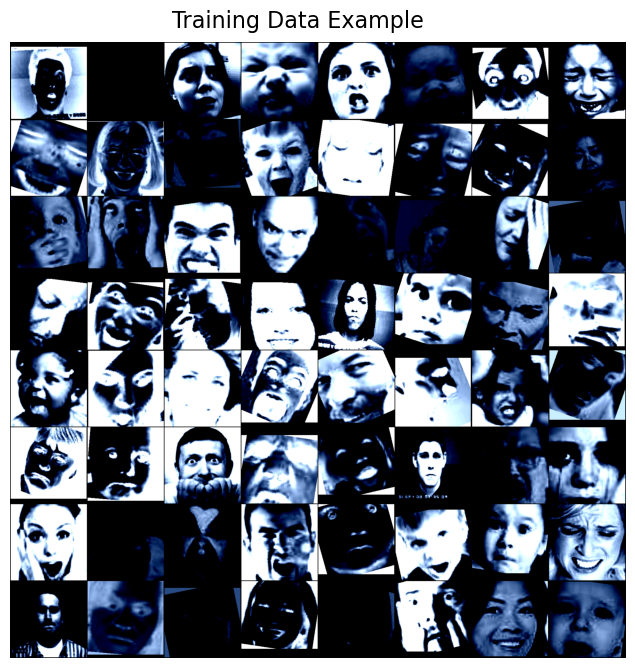

In [72]:
# Iterate over the training data loader
for images, _ in train_dl:
    # Print the shape of the images tensor
    print('images.shape:', images.shape)
    
    # Create a figure to display the images
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    
    # Display the images as a grid
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # Move the channel dimension
    
    # Break the loop after processing the first batch
    break

# Set the title for the figure
_ = plt.suptitle("Training Data Example", y=0.92, fontsize=16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


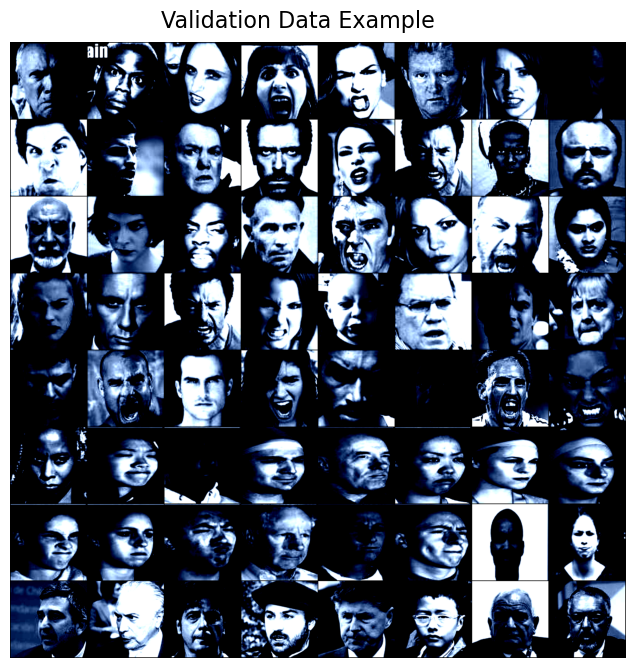

In [73]:
# Iterate over the training data loader
for images, _ in val_dl:
    # Print the shape of the images tensor
    print('images.shape:', images.shape)
    
    # Create a figure to display the images
    plt.figure(figsize=(16, 8))
    plt.axis("off")
    
    # Display the images as a grid
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # Move the channel dimension
    
    # Break the loop after processing the first batch
    break

# Set the title for the figure
_ = plt.suptitle("Validation Data Example", y=0.92, fontsize=16)


## Helper Functions

In [26]:
def get_default_device(mps=False):
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

device = get_default_device()
print(f"Default torch device is: {device}")


Default torch device is: cuda


In [27]:
def training(net, n_epochs, optimizer, loss_function, train_dl, verbose=True, patience = 3):
  # Store the losses for each epoch
  loss_train_list = []
  loss_valid_list = []

  # Store the accuracy for each epoch
  acc_train_list = []
  acc_valid_list = []

  # needed for stopping
  the_last_loss = 0
  trigger_times = 0 

  training_start_time = time.time() # to know how long each epoch takes

  # Iterate over the dataset n_epochs times
  for epoch in tqdm(range(n_epochs)):
    net.train()  # net.train() will notify all your layers that you are in training mode

    train_loss = 0  # Training loss in epoch
    num_train_correct  = 0
    num_train_examples = 0

    # For each batch, pass the training examples, calculate loss and gradients and optimize the parameters
    for xb, yb in train_dl:
      optimizer.zero_grad()  # zero_grad clears old gradients from the last step

      xb = xb.to(device)
      yb = yb.to(device)

      y_hat = net(xb)  # Forward pass
      loss = loss_function(y_hat, yb)  # Calculate Loss
      
      loss.backward()  # Calculate the gradients (using backpropagation)
      optimizer.step()  # # Optimize the parameters: opt.step() causes the optimizer to take a step based on the gradients of the parameters.
      
      
      train_loss += loss.item()
      num_train_correct += (torch.max(y_hat, 1)[1] == yb).sum().item()
      num_train_examples += xb.shape[0]
    
    train_acc = num_train_correct / num_train_examples
    
    valid_loss = 0  # Validation loss in epoch
    num_val_correct  = 0
    num_val_examples = 0

    net.eval()  # net.eval() will notify all your layers that you are in evaluation mode
    # torch.no_grad() impacts the autograd engine and deactivate it. It will reduce memory usage and speed 
    # up computations but you won’t be able to backprop (which you don’t want in an evaluation script).
    with torch.no_grad():
      # Perform a prediction on the validation set  
      for xb_valid, yb_valid in val_dl:
        xb_valid = xb_valid.to(device)
        yb_valid = yb_valid.to(device)

        y_hat = net(xb_valid)  # Forward pass
        loss = loss_function(y_hat, yb_valid)  # Calculate Loss

        valid_loss += loss.item()
        num_val_correct += (torch.max(y_hat, 1)[1] == yb_valid).sum().item()
        num_val_examples += xb_valid.shape[0]
    
    val_acc = num_val_correct / num_val_examples

    #Early stopping
    the_current_loss = valid_loss

    if the_current_loss > the_last_loss:
      trigger_times += 1

      if trigger_times >= patience:
        print('Early stopping!')
        return acc_train_list, acc_valid_list, loss_train_list, loss_valid_list

    else:
      trigger_times = 0

    the_last_loss = the_current_loss
    

    if verbose:
    # print everything nicely
      print('Epoch: {} \t Total_Time: {:.2f} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
        epoch+1,
        (time.time() - training_start_time),
        train_loss,
        valid_loss,
        train_acc * 100,
        val_acc *100
        )) 

    loss_train_list.append(train_loss)
    loss_valid_list.append(valid_loss)
    acc_train_list.append(100 * (train_acc))
    acc_valid_list.append(100 * (val_acc))

  return acc_train_list, acc_valid_list, loss_train_list, loss_valid_list

## Transfer Learning

### Resnet18

In [ ]:
# Load pre-trained model
resnet18_fine_model = resnet18(pretrained=True)

# Freeze all the parameters in the pre-trained model
for param in resnet18_fine_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the desired output size
resnet18_fine_model.fc = nn.Linear(512, 5)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the desired device (e.g., 'cuda' if available)
resnet18_fine_model.to(device)

# Create the optimizer for the fine-tuning process
optimizer = optim.Adam(resnet18_fine_model.parameters(), lr=0.001)

# Train the model for one epoch with frozen parameters
acc_train, acc_valid, loss_train, loss_valid = training(net=resnet18_fine_model, n_epochs=10, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Unfreeze the parameters for further fine-tuning
for param in resnet18_fine_model.parameters():
    param.requires_grad = True

# Fine-tuning with different learning rates
learning_rates = [0.0001, 0.00001, 0.000001]
for lr in learning_rates:
    optimizer = optim.Adam(resnet18_fine_model.parameters(), lr=lr)
    acc_train, acc_valid, loss_train, loss_valid = training(net=resnet18_fine_model, n_epochs=5, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Save the finetuned model's state dictionary to a file
torch.save(resnet18_fine_model.state_dict(), "resnet18_fine_model.pth")


### Resnet 50

In [ ]:
# Load pre-trained model
resnet50_fine_model = resnet50(pretrained=True)

# Freeze all the parameters in the pre-trained model
for param in resnet50_fine_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the desired output size
resnet50_fine_model.fc = nn.Linear(2048, 5)

# Define the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the desired device (e.g., 'cuda' if available)
resnet50_fine_model.to(device)

# Create the optimizer for the fine-tuning process
optimizer = optim.Adam(resnet50_fine_model.parameters(), lr=0.001)

# Train the model for one epoch with frozen parameters
acc_train, acc_valid, loss_train, loss_valid = training(net=resnet50_fine_model, n_epochs=10, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Unfreeze the parameters for further fine-tuning
for param in resnet50_fine_model.parameters():
    param.requires_grad = True

# Fine-tuning with different learning rates
learning_rates = [0.0001, 0.00001, 0.000001]
for lr in learning_rates:
    optimizer = optim.Adam(resnet50_fine_model.parameters(), lr=lr)
    acc_train, acc_valid, loss_train, loss_valid = training(net=resnet50_fine_model, n_epochs=5, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Save the finetuned model's state dictionary to a file
torch.save(resnet50_fine_model.state_dict(), "resnet50_fine_model.pth")

### EfficientNet

In [ ]:
torch.cuda.empty_cache()

# Load pre-trained EfficientNet-B0 model
efficientnet_b0_fine_model = efficientnet_b0(pretrained=True)

# Modify the last fully connected layer to match the desired output size
efficientnet_b0_fine_model.fc = nn.Linear(512, 5)

# Define the optimizer and learning rates
learning_rates = [0.001, 0.0001, 0.00001]
epochs = 10

# Create the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the desired device (e.g., 'cuda' if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
efficientnet_b0_fine_model.to(device)

# Fine-tuning with different learning rates
for lr in learning_rates:
    # Create the optimizer with the current learning rate
    optimizer = optim.Adam(efficientnet_b0_fine_model.parameters(), lr=lr)

    # Train the model for 'epochs' epochs with the current optimizer and loss function
    acc_train, acc_valid, loss_train, loss_valid = training(net=efficientnet_b0_fine_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Save the fine-tuned model's state dictionary to a file
torch.save(efficientnet_b0_fine_model.state_dict(), "efficientnet_b0_fine_model.pth")


### Inception_v3

In [ ]:
# Load pretrained Inception_v3 model
inception_v3_fine_model = inception_v3(pretrained=True)
inception_v3_fine_model.aux_logits = False

# Freeze all the parameters in the pre-trained model
for param in inception_v3_fine_model.parameters():
    param.requires_grad = False

# Modify the fully connected layer to match the number of classes
inception_v3_fine_model.fc = nn.Linear(2048, 5)

# Define the optimizer with a learning rate of 0.001
optimizer = optim.Adam(inception_v3_fine_model.parameters(), lr=0.001)

# Define the number of epochs
epochs = 5

# Create the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the appropriate device
inception_v3_fine_model.to(device)

# Training using the provided training function and data loader
acc_train, acc_valid, loss_train, loss_valid = training(net=inception_v3_fine_model, n_epochs=epochs, optimizer=optimizer, loss_function=loss_function, train_dl=inception_train_dl)

# Enable gradient calculation for fine-tuning
for param in inception_v3_fine_model.parameters():
    param.requires_grad = True

# Fine-tuning with different learning rates
learning_rates = [0.0001, 0.00001, 0.000001]
for lr in learning_rates:
    # Create a new optimizer with the specified learning rate
    optimizer = optim.Adam(inception_v3_fine_model.parameters(), lr=lr)
    
    # Train the model for 5 epochs with the new learning rate
    acc_train, acc_valid, loss_train, loss_valid = training(net=inception_v3_fine_model, n_epochs=5, optimizer=optimizer, loss_function=loss_function, train_dl=inception_train_dl)

# Save the finetuned model's state dictionary to a file
torch.save(inception_v3_fine_model.state_dict(), "inception_v3_fine_model.pth")

### mobilenet

In [ ]:
# Load pretrained MobileNetV3 model
mobilenet_v3_fine_model = mobilenetv3.mobilenet_v3_large(pretrained=True)

# Modify the fully connected layer to match the number of classes
mobilenet_v3_fine_model.fc = nn.Linear(1024, 5)

# Create the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the appropriate device
mobilenet_v3_fine_model.to(device)

# Define a list of learning rates to iterate over
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]

# Fine-tuning with different learning rates
for lr in learning_rates:
    # Create a new optimizer with the specified learning rate
    optimizer = optim.Adam(mobilenet_v3_fine_model.parameters(), lr=lr)
    
    # Train the model for 10 epochs with the new learning rate
    acc_train, acc_valid, loss_train, loss_valid = training(net=mobilenet_v3_fine_model, n_epochs=10, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Save the finetuned model's state dictionary to a file
torch.save(mobilenet_v3_fine_model.state_dict(), "mobilenet_v3_fine_model.pth")


### mnasnet

In [ ]:
# Load pretrained MnasNet model
mnasnet_fine_model = mnasnet.mnasnet1_0(pretrained=True)

# Modify the fully connected layer to match the number of classes
mnasnet_fine_model.fc = nn.Linear(512, 5)

# Create the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the appropriate device
mnasnet_fine_model.to(device)

# Define a list of learning rates to iterate over
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]

# Fine-tuning with different learning rates
for lr in learning_rates:
    # Create a new optimizer with the specified learning rate
    optimizer = optim.Adam(mnasnet_fine_model.parameters(), lr=lr)
    
    # Train the model for 10 epochs with the new learning rate
    acc_train, acc_valid, loss_train, loss_valid = training(net=mnasnet_fine_model, n_epochs=10, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Save the finetuned model's state dictionary to a file
torch.save(mnasnet_fine_model.state_dict(), "mnasnet_fine_model.pth")


### GoogleNet

In [ ]:
# Load pretrained GoogLeNet model
googlenet_fine_model = models.googlenet(pretrained=True)

# Modify the fully connected layer to match the number of classes
googlenet_fine_model.fc = nn.Linear(1024, 5)

# Create the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the appropriate device
googlenet_fine_model.to(device)

# Define a list of learning rates to iterate over
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]

# Fine-tuning with different learning rates
for lr in learning_rates:
    # Create a new optimizer with the specified learning rate
    optimizer = optim.Adam(googlenet_fine_model.parameters(), lr=lr)
    
    # Train the model for 10 epochs with the new learning rate
    acc_train, acc_valid, loss_train, loss_valid = training(net=googlenet_fine_model, n_epochs=10, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Save the finetuned model's state dictionary to a file
torch.save(googlenet_fine_model.state_dict(), "googlenet_fine_model.pth")

### ShuffleNet

In [ ]:
   
# Load pretrained Shufflenet model
shufflenet_fine_model = models.shufflenet_v2_x1_0(pretrained=True)

# Modify the fully connected layer to match the number of classes
shufflenet_fine_model.fc = nn.Linear(1024, 5)

# Create the loss function
loss_function = nn.CrossEntropyLoss()

# Move the model to the appropriate device
shufflenet_fine_model.to(device)

# Define a list of learning rates to iterate over
learning_rates = [0.001, 0.0001, 0.00001, 0.000001]

# Fine-tuning with different learning rates
for lr in learning_rates:
    # Create a new optimizer with the specified learning rate
    optimizer = optim.Adam(shufflenet_fine_model.parameters(), lr=lr)
    
    # Train the model for 10 epochs with the new learning rate
    acc_train, acc_valid, loss_train, loss_valid = training(net=shufflenet_fine_model, n_epochs=10, optimizer=optimizer, loss_function=loss_function, train_dl=train_dl)

# Save the finetuned model's state dictionary to a file
torch.save(shufflenet_fine_model.state_dict(), "shufflenet_fine_model.pth")


## Load fine tuned models

In [ ]:
#device = "cpu"

### Resnet 18


In [ ]:
if training == True: 
    # Load pretrained ResNet18 model
    resnet18_fine_model = models.resnet18(pretrained=True)

    # Freeze all the parameters in the pre-trained model
    for param in resnet18_fine_model.parameters():
        param.requires_grad = False

    # Modify the fully connected layer to match the number of classes
    resnet18_fine_model.fc = nn.Linear(512, 5)

    # Load the pretrained model's state dictionary
    resnet18_fine_model.load_state_dict(torch.load("resnet18_fine_model.pth", map_location = device))
    resnet18_fine_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Resnet 50

In [ ]:
if training == True: 

    # Load pretrained ResNet50 model
    resnet50_fine_model = models.resnet18(pretrained=True)

    # Freeze all the parameters in the pre-trained model
    for param in resnet18_fine_model.parameters():
        param.requires_grad = False

    # Modify the fully connected layer to match the number of classes
    resnet50_fine_model.fc = nn.Linear(2048, 5)

    # Load the pretrained model's state dictionary
    resnet50_fine_model.load_state_dict(torch.load("resnet50_fine_model.pth", map_location = device))
    resnet50_fine_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### EfficientNet


In [ ]:
# Load pretrained EfficientNet model
resnet50_fine_model = models.resnet18(pretrained=True)

# Modify the fully connected layer to match the number of classes
efficientnet_b0_fine_model.fc = nn.Linear(512, 5)

# Load the pretrained model's state dictionary
efficientnet_b0_fine_model.load_state_dict(torch.load("efficientnet_b0_fine_model.pth", map_location = device))
efficientnet_b0_fine_model.to(device)


EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

### Inception 

In [ ]:
# Load pretrained model
inception_v3_fine_model = inception_v3(pretrained=True)
inception_v3_fine_model.aux_logits = False

# Modify the fully connected layer to match the number of classes
inception_v3_fine_model.fc = nn.Linear(2048, 5)

# Load the pretrained model's state dictionary
inception_v3_fine_model.load_state_dict(torch.load("inception_v3_fine_model", map_location = device))
inception_v3_fine_model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

### mobilenet

In [ ]:
# Load pretrained model
mobilenet_v3_fine_model = mobilenetv3.mobilenet_v3_large(pretrained=True)

# Modify the fully connected layer to match the number of classes
mobilenet_v3_fine_model.fc = nn.Linear(1024, 5)


# Load the pretrained model's state dictionary
mobilenet_v3_fine_model.load_state_dict(torch.load("mobilenet_v3_fine_model.pth", map_location = device))
mobilenet_v3_fine_model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False

### mnasnet



In [ ]:
# Load pretrained model
mnasnet_fine_model = mnasnet.mnasnet1_0(pretrained=True)

# Modify the fully connected layer to match the number of classes
mnasnet_fine_model.fc = nn.Linear(512, 5)

# Load the pretrained model's state dictionary
mnasnet_fine_model.load_state_dict(torch.load("mnasnet_fine_model.pth", map_location = device))
mnasnet_fine_model.to(device)



MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

### SqueezeNet

In [ ]:
# Load pretrained model
squeezenet_fine_model = models.squeezenet1_0(pretrained=True)

# Modify the fully connected layer to match the number of classes
squeezenet_fine_model.fc = nn.Linear(1024, 5)

# Load the pretrained model's state dictionary
squeezenet_fine_model.load_state_dict(torch.load("squeezenet_fine_model.pth", map_location = device))
squeezenet_fine_model.to(device)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

### GoogleNet

In [ ]:
# Load pretrained model
googlenet_fine_model = models.googlenet(pretrained=True)

# Modify the fully connected layer to match the number of classes
googlenet_fine_model.fc = nn.Linear(1024, 5)

# Load the pretrained model's state dictionary
googlenet_fine_model.load_state_dict(torch.load("googlenet_fine_model.pth", map_location = device))
googlenet_fine_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

### Shufflenet

In [ ]:
# Load pretrained model
shufflenet_fine_model = models.shufflenet_v2_x1_0(pretrained=True)

# Modify the fully connected layer to match the number of classes
shufflenet_fine_model.fc = nn.Linear(1024, 5)

# Load the pretrained model's state dictionary
shufflenet_fine_model.load_state_dict(torch.load("shufflenet_fine_model.pth", map_location = device))
shufflenet_fine_model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

## Predictions

In [43]:
def get_true_pred(model, data_loader, device="cpu"):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize counters for correct and total predictions for each class
    class_correct = list(0. for i in range(5))
    class_total = list(0. for i in range(5))
    
    # Lists to store true and predicted labels
    y_pred = []
    y_true = []
    
    # Move the model to the specified device
    model.to(device)
    model.eval()
    
    # Iterate over the data loader
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        
        # Forward pass through the model
        output = model(x)
        
        # Get the predicted labels
        _, pred = torch.max(output, 1)
        
        # Append the predicted and true labels to the respective lists
        y_pred.append(pred.tolist())
        y_true.append(y.tolist())
    
    # Flatten the true and predicted label lists
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]
    
    # Clear the model and tensors from GPU memory
    model = model.to("cpu")
    x = x.to("cpu")
    y = y.to("cpu")
    del model, x, y
    
    if device == "cuda": 
        # Empty the GPU cache
        torch.cuda.empty_cache()
    
    return y_true_flat, y_pred_flat


In [44]:
# For classification report
target_names = ["angry", "fear", "happy", "sad", "suprise"]


### Resnet 18

In [45]:
# Use Model to make predicition and create classification report 
res_18_y_true, res_18_y_pred = get_true_pred(resnet18_fine_model, val_dl)
print(classification_report(res_18_y_true, res_18_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.79      0.81      0.80       400
        fear       0.71      0.68      0.69       222
       happy       0.85      0.88      0.87       400
         sad       0.77      0.80      0.79       400
     suprise       0.83      0.77      0.80       400

    accuracy                           0.80      1822
   macro avg       0.79      0.79      0.79      1822
weighted avg       0.80      0.80      0.80      1822



### ResNet50


In [46]:
# Use Model to make predicition and create classification report 
res_50_y_true, res_50_y_pred = get_true_pred(resnet50_fine_model, val_dl)
print(classification_report(res_50_y_true, res_50_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.79      0.84      0.82       400
        fear       0.71      0.67      0.69       222
       happy       0.88      0.89      0.88       400
         sad       0.82      0.79      0.80       400
     suprise       0.82      0.82      0.82       400

    accuracy                           0.81      1822
   macro avg       0.80      0.80      0.80      1822
weighted avg       0.81      0.81      0.81      1822



### Efficient Net

In [47]:
# Use Model to make predicition and create classification report 
efficent_y_true, efficent_y_pred = get_true_pred(efficientnet_b0_fine_model, val_dl)
print(classification_report(efficent_y_true, efficent_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.84      0.85      0.85       400
        fear       0.76      0.68      0.72       222
       happy       0.93      0.91      0.92       400
         sad       0.83      0.85      0.84       400
     suprise       0.83      0.85      0.84       400

    accuracy                           0.85      1822
   macro avg       0.84      0.83      0.83      1822
weighted avg       0.84      0.85      0.84      1822



### Inception

In [48]:
# Use Model to make predicition and create classification report 
inception_y_true, inception_y_pred = get_true_pred(inception_v3_fine_model, inception_val_dl)
print(classification_report(inception_y_true, inception_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.77      0.81      0.79       400
        fear       0.72      0.66      0.69       222
       happy       0.89      0.87      0.88       400
         sad       0.79      0.78      0.78       400
     suprise       0.79      0.81      0.80       400

    accuracy                           0.80      1822
   macro avg       0.79      0.79      0.79      1822
weighted avg       0.80      0.80      0.80      1822



### mobilenet

In [49]:
# Use Model to make predicition and create classification report 
mobilenet_y_true, mobilenet_y_pred = get_true_pred(mobilenet_v3_fine_model, val_dl)
print(classification_report(mobilenet_y_true, mobilenet_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.81      0.86      0.84       400
        fear       0.74      0.69      0.71       222
       happy       0.91      0.90      0.91       400
         sad       0.84      0.82      0.83       400
     suprise       0.82      0.83      0.82       400

    accuracy                           0.83      1822
   macro avg       0.82      0.82      0.82      1822
weighted avg       0.83      0.83      0.83      1822



### mnasnet

In [50]:
# Use Model to make predicition and create classification report 
mnasnet_y_true, mnasnet_y_pred = get_true_pred(mnasnet_fine_model, val_dl)
print(classification_report(mnasnet_y_true, mnasnet_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.80      0.83      0.82       400
        fear       0.74      0.64      0.68       222
       happy       0.82      0.93      0.87       400
         sad       0.79      0.76      0.77       400
     suprise       0.81      0.77      0.79       400

    accuracy                           0.80      1822
   macro avg       0.79      0.78      0.79      1822
weighted avg       0.80      0.80      0.80      1822



### GoogleNet

In [51]:
# Use Model to make predicition and create classification report 
google_y_true, google_y_pred = get_true_pred(googlenet_fine_model, val_dl)
print(classification_report(google_y_true, google_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.80      0.85      0.83       400
        fear       0.76      0.68      0.71       222
       happy       0.90      0.89      0.90       400
         sad       0.81      0.83      0.82       400
     suprise       0.84      0.83      0.83       400

    accuracy                           0.83      1822
   macro avg       0.82      0.82      0.82      1822
weighted avg       0.83      0.83      0.83      1822



### ShuffleNet

In [52]:
# Use Model to make predicition and create classification report 
shuffle_y_true, shuffle_y_pred = get_true_pred(shufflenet_fine_model, val_dl)
print(classification_report(shuffle_y_true, shuffle_y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.83      0.80      0.81       400
        fear       0.74      0.66      0.70       222
       happy       0.85      0.90      0.87       400
         sad       0.80      0.81      0.81       400
     suprise       0.79      0.80      0.79       400

    accuracy                           0.81      1822
   macro avg       0.80      0.80      0.80      1822
weighted avg       0.81      0.81      0.81      1822



## Ensemble/Majority Voting Approach

In [ ]:
# create a new dataframe to store all prediction results
df = pd.DataFrame(columns=["res18","res50","efficent","inception", "mobilenet","mnasnet", "google", "shuffle"])

# fill the predicted values
df.res18 = res_18_y_pred
df.res50 = res_50_y_pred
df.efficent = efficent_y_pred
df.inception = inception_y_pred
df.mobilenet = mobilenet_y_pred
df.mnasnet = mnasnet_y_pred
df.google = google_y_pred
df.shuffle = shuffle_y_pred

# true value as reference
df.true = res_18_y_true

# majority vote based mode
df['majority'] = df[["res18","res50","efficent","inception", "mobilenet","mnasnet", "google", "shuffle"]].mode(axis=1)[0]

# store results
df.to_csv("df_ensemble.csv", index=False)

In [54]:
# look at confusion matrix 
target_names = ["angry", "fear", "happy", "sad", "suprise"]
print(classification_report(df.true, df.majority, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.82      0.90      0.86       400
        fear       0.77      0.69      0.73       222
       happy       0.91      0.91      0.91       400
         sad       0.84      0.84      0.84       400
     suprise       0.86      0.82      0.84       400

    accuracy                           0.85      1822
   macro avg       0.84      0.83      0.84      1822
weighted avg       0.85      0.85      0.85      1822



### Evaluation of best peforming model combination 

In [60]:
result = []  # List to store f1 scores
names = []  # List to store combinations of models

# Iterate over different sizes of combinations from 5 to 11
for x in list(range(5, 12)):
    list_of_combis = itertools.combinations(["res18", "res50", "efficent", "inception", "mobilenet", "mnasnet", "google", "shuffle"], x)
    
    # Iterate over each combination of models
    for subset in list_of_combis:
        combis = []
        
        # Create a list of models in the current combination
        for i in subset:
            combis.append(i)
        
        # Calculate the majority prediction using the current combination of models
        df['majority'] = df[combis].mode(axis=1)[0]
        
        # Append the combination to the names list
        names.append(combis)
        
        # Calculate the f1 score and append it to the result list
        result.append(f1_score(df.true, df.majority, average='weighted'))

# Create a DataFrame to store the combinations and f1 scores
df_combi = pd.DataFrame(columns=["combination", "f1_score"])
df_combi.combination = names
df_combi.f1_score = result

# Set display options for DataFrame
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Save the DataFrame to a CSV file
df_combi.to_csv("df_combi.csv", index=False)

# Sort the DataFrame by f1_score in descending order
df_combi.sort_values(by='f1_score', ascending=False)


C:\Users\timra\AppData\Local\Temp\ipykernel_13024\3741704936.py:35: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



,combination,f1_score
41,"[res50, efficent, mobilenet, mnasnet, google]",0.851690
26,"[res18, efficent, mobilenet, mnasnet, google]",0.851467
77,"[res50, efficent, inception, mobilenet, mnasnet, google]",0.849493
62,"[res18, res50, efficent, mobilenet, mnasnet, google]",0.849314
43,"[res50, efficent, mobilenet, google, shuffle]",0.848939
...,...,...
33,"[res18, inception, mnasnet, google, shuffle]",0.832254
31,"[res18, inception, mobilenet, mnasnet, shuffle]",0.832214
3,"[res18, res50, efficent, inception, shuffle]",0.831859
15,"[res18, res50, inception, google, shuffle]",0.829746


I choose the following model combination:  res50, efficent, mobilenet, mnasnet, google

## Final Submission

In [63]:
# create dataframe for final sumission
df_final = pd.DataFrame(columns=["file","res50", "efficent", "mobilenet", "mnasnet", "googlenet", "majority"])


In [65]:
# Read the submission dataframe from the CSV file
submission_df = pd.read_csv("submission.csv")

# Assign the 'file' column from the submission dataframe to the 'file' column in df_final
df_final.file = submission_df.file

# Function to generate predictions for test images using the given model
def test_prediction(model, size=(224, 224)):
    results = []
    
    # Define the transformation for test images
    transformer_test = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) 
    
    # Set the model to evaluation mode and move it to the CPU
    model.eval()
    model.to('cpu')
    
    # Process each test image
    for fileName in submission_df.file:
        # Load and convert the image to RGB
        image = Image.open("test/all/" + fileName).convert('RGB')
        
        # Generate the prediction for the image
        pred = int(model(transformer_test(image).unsqueeze_(0)).argmax())
        
        # Append the predicted label to the results list
        results.append(output_label(pred))
    
    # Clear CUDA cache and delete the model
    torch.cuda.empty_cache()
    del model
    
    return results


In [ ]:
# Generate predictions for each model and assign them to respective columns in the dataframe
df_final['res50'] = test_prediction(resnet50_fine_model)
df_final['efficent'] = test_prediction(efficientnet_b0_fine_model)
df_final['mobilenet'] = test_prediction(mobilenet_v3_fine_model)
df_final['mnasnet'] = test_prediction(mnasnet_fine_model)
df_final['googlenet'] = test_prediction(googlenet_fine_model)

# Determine the majority prediction from the models and assign it to a new column
df_final['majority'] = df_final[["res50", "efficent", "mobilenet", "mnasnet", "googlenet", "majority"]].mode(axis=1)[0]

# Save the final dataframe to a CSV file
df_final.to_csv("df_final.csv", index=False)

# Create a submission dataframe with the required columns
submission_df = df_final[["file", "majority"]]

# Rename the 'majority' column to 'emotions' in the submission dataframe
submission_df.rename({'majority': 'emotions'}, axis=1, inplace=True)

# Save the submission dataframe to a CSV file
submission_df.to_csv("submission_solution.csv", index=False)

# Display the count of each emotion in the 'emotions' column of the submission dataframe
submission_df.emotions.value_counts()


Done